# Mask Example

This script demonstrates the use of masks for modifying and thresholding
data.  Specifically, it demonstrates processes such as creating masks,
copying and changing values in a mask, and plotting masks.

## Setup

In [1]:
# -*- coding: utf-8 -*-
%matplotlib nbagg
%matplotlib  

from matplotlib.pyplot import figure, show, subplots_adjust
from echolab2.instruments import EK60
from echolab2.plotting.matplotlib import echogram
from echolab2.processing import mask

Using matplotlib backend: nbAgg


## Read in data

In [2]:
# Read in some data from files.
rawfiles = ['./data/EK60/PC1106-D20110830-T052815.raw',
            './data/EK60/PC1106-D20110830-T053815.raw']

ek60 = EK60.EK60()
ek60.read_raw(rawfiles)

## Parse the data

In [3]:
# Get a reference to the RawData object.
raw_data_38 = ek60.get_raw_data(channel_number=2)
print(raw_data_38)

# Get a ProcessedData object containing Sv.
Sv = raw_data_38.get_Sv()
print(Sv)

# Create a copy of Sv to compare against the copy we will manipulate.
orig_Sv = Sv.copy()

<class 'echolab2.instruments.EK60.RawData'> at 0x11dbe4198
                channel(s): [GPT  38 kHz 0090720346b4 1-1 ES38]
    frequency (first ping): 38000.0
 pulse length (first ping): 0.001024
           data start time: 2011-08-30T05:28:15.765
             data end time: 2011-08-30T05:51:29.343
           number of pings: 922
    power array dimensions: (922,1260)
    angle array dimensions: (922,1260)

<class 'echolab2.processing.processed_data.ProcessedData'> at 0x108270518
                channel(s): [GPT  38 kHz 0090720346b4 1-1 ES38]
                 frequency: 38000.0
           data start time: 2011-08-30T05:28:15.765
             data end time: 2011-08-30T05:51:29.343
            number of pings: 922
            data attributes: ping_time (922)
                            data (922,1260)
                            range (1260)



## Create some masks
Create a couple of masks.  Masks come in two types.  "Ping" masks are 1d masks that apply to all samples in a ping, while "sample" masks are 2d masks and apply to the individual sample data elements.

Mask objects are comprised of either a 2d or 1d boolean array and one or two 1d arrays containing the axes for the array.  When applying masks, the axes are checked against the axes of the object you're applying the mask to and they must be the same.  Because of this, most of the time you will create a mask that is "like" an existing ProcessedData object, which
results in the mask array being sized correctly for the ProcessedData object and the axes are copied from the ProcessedData object and thus are the same.

In [4]:
# The default behavior of the constructor is to create a sample mask so we'll
# create a sample mask that is like our "Sv" ProcessedData object.
sample_mask = mask.Mask(like=Sv)
print(sample_mask)

# Masks are by default created with all elements set to "False".  You can use
# the value keyword of the constructor to set it to True if you so desire.

# Create a ping mask like Sv, setting all values to True.
ping_mask = mask.Mask(like=Sv, type='ping', value=True)
print(ping_mask)

# Masks can be used on their own to present data (though mask plotting isn't
# implemented yet) or more commonly used as a logical index array to operate on
# specific samples in a ProcessedData object.  Since mask plotting isn't
# implemented, we'll focus on the second, more common use.

# At the most basic level, setting mask elements to True will specify that
# an operation occurs on that element.  For example, if we wanted to set
# a block of samples between sample 50 and 800 from ping 20-500 to -999
# we could set those mask values to True and then use the mask to "index"
# into our ProcessedData object Sv.
sample_mask.mask[20:500, 50:800] = True

# Now use the mask to set these samples to -999.
Sv[sample_mask] = -999

<class 'echolab2.processing.mask.Mask'> at 0x1068fa358
                 mask name: Mask
                      type: sample
                     color: [148, 0, 211]
                dimensions: (922,1260)
             sample offset: 0

<class 'echolab2.processing.mask.Mask'> at 0x10828d080
                 mask name: Mask
                      type: ping
                     color: [148, 0, 211]
                dimensions: (922)



## Plot the data

<IPython.core.display.Javascript object>


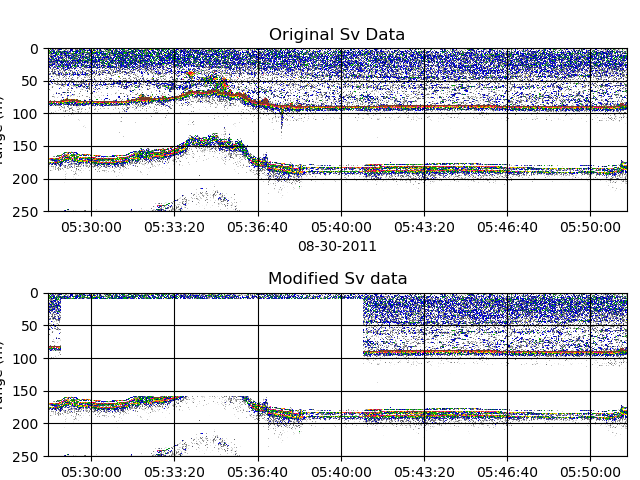

In [5]:
# Create a matplotlib figure to plot our echograms on.
fig = figure()
subplots_adjust(left=0.075, bottom=.05, right=0.98, top=.90, wspace=None,
                hspace=0.5)

# Plot the original data.
ax1 = fig.add_subplot(2, 1, 1)
eg = echogram.Echogram(ax1, orig_Sv, threshold=[-70, -34])
ax1.set_title("Original Sv Data")

# Plot the data we modified.
ax2 = fig.add_subplot(2, 1, 2)
eg = echogram.Echogram(ax2, Sv, threshold=[-70, -34])
ax2.set_title('Modified Sv data')

# Display the results.
show()

But that's not really how you would use a mask since you can set rectangular regions directly by slicing the ProcessedData object. Thresholding is a more realistic example of using a mask.

## Plot the data using thresholding

<IPython.core.display.Javascript object>


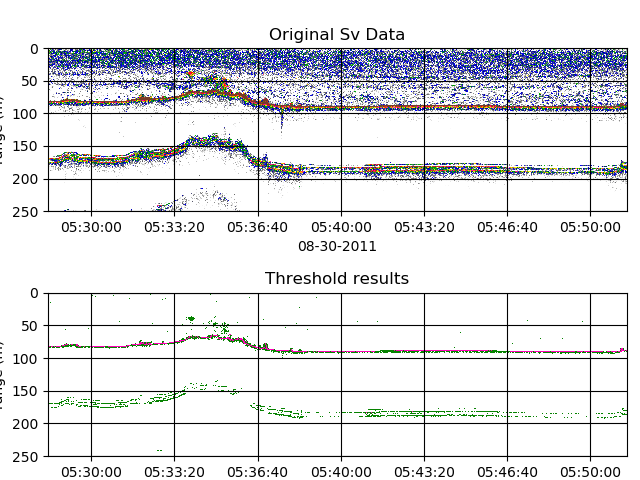

In [6]:
# Using Python comparison operators with ProcessedData objects will return
# masks so thresholding is as simple as using <, >, <=, >=, etc.

Sv = orig_Sv.copy()

# The comparison operators work on scalars.  Create 3 masks, each with a
# different threshold.
mask_1 = Sv < -70
mask_3 = Sv > -25

# You can apply boolean operators to masks as well, which also returns a mask.
# Just make sure you group the operations properly.
mask_2 = (Sv >= -50) & (Sv <= -25)

# Instead of using the masks to set values in the original Sv object, let's
# create a ProcessedData object that is a copy of Sv with the sample data set
# to zeros.
synth_data = Sv.zeros_like()

# Now set the values in our new ProcessedData object.
synth_data[mask_1] = 0
synth_data[mask_2] = 10
synth_data[mask_3] = 15

# Create a matplotlib figure to plot our echograms on.
fig = figure()
subplots_adjust(left=0.075, bottom=.05, right=0.98, top=.90, wspace=None,
                hspace=0.5)

# Plot the original data.
ax1 = fig.add_subplot(2, 1, 1)
eg = echogram.Echogram(ax1, orig_Sv, threshold=[-70, -34])
ax1.set_title("Original Sv Data")

# Plot the data we modified.
ax2 = fig.add_subplot(2, 1, 2)
eg = echogram.Echogram(ax2, synth_data, threshold=[0, 20])
ax2.set_title('Threshold results')

# Display the results.
show()